# SAE 15 : Consommation énergétique d'un dispositif LoRa

In [4]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Fusion des fichiers

In [5]:
# Obtenir la liste de tous les fichiers que nous voulons fusionner
file_list = os.listdir(r'C:\Users\Shpend\Downloads\lora-energie-transmission\lora-energie-transmission\data\raw')

#Parcourez la liste de fichiers, transformez chacun en un DataFrame et ajoutez-les dans les "données" DF
data = pd.DataFrame()
for f in file_list[1:]:
    df = pd.read_csv(r'lora-energie-transmission\data\raw\\'+f)
    data = data.append(df, ignore_index=True)
    df.to_csv("dataframe.csv", index=False)
data.shape

(2682781, 5)

# Valeurs aberrantes et manquantes par variables

In [6]:
# Cette ligne donne un tableau du nombre de valeurs manquantes dans chaque colonne
# dans le même ordre que dans la trame de données
missing = data.isnull().sum().values
for i in zip(data.columns, missing):
    print(f'Nous avons {i[1]} valeurs manquantes pour la variable \"{i[0]}\".\n'
    +f'Cela represent {round(i[1]/data.shape[0]*100, 4)}% des entrées de cette colonne\n')

Nous avons 0 valeurs manquantes pour la variable "Timestamp (S)".
Cela represent 0.0% des entrées de cette colonne

Nous avons 93 valeurs manquantes pour la variable "File Main Current (A)".
Cela represent 0.0035% des entrées de cette colonne

Nous avons 2012103 valeurs manquantes pour la variable "File Main Voltage (V)".
Cela represent 75.0006% des entrées de cette colonne

Nous avons 93 valeurs manquantes pour la variable "File Main Energy (J)".
Cela represent 0.0035% des entrées de cette colonne

Nous avons 2679465 valeurs manquantes pour la variable "File UART (TXT)".
Cela represent 99.8764% des entrées de cette colonne



In [7]:
data.describe()

,Timestamp (S),File Main Current (A),File Main Voltage (V),File Main Energy (J)
count,2.682781e+06,2.682688e+06,670678.000000,2.682688e+06
mean,4.510311e+01,1.203362e-01,3.499543,1.911122e+01
std,2.916519e+01,2.814267e-02,0.000802,1.326596e+01
min,-1.000000e-06,3.624300e-02,3.493000,3.225147e-05
25%,2.095625e+01,1.300810e-01,3.499000,8.034673e+00
50%,4.191550e+01,1.306570e-01,3.500000,1.753946e+01
75%,6.524025e+01,1.309860e-01,3.500000,2.835552e+01
max,1.189260e+02,1.351800e-01,3.507000,5.137382e+01


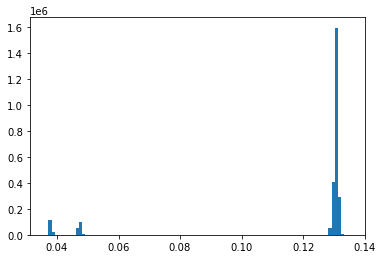

In [8]:
plt.figure()
plt.hist(data['File Main Current (A)'], bins=100);

In [10]:
x = data[data['File Main Current (A)']<0.06].shape[0]
pourcentage = round(x/data.shape[0]*100, 2)
print(f'{pourcentage}% des valeurs dans \"File Main Current (A)\" écartent fortement de la moyenne, ce sont {x} valeurs')

11.58% des valeurs dans "File Main Current (A)" écartent fortement de la moyenne, ce sont 310761 valeurs


Même si ces valeurs sont assez nombreux, ils ne se trouvent pas distribués entre la moyenne et la plus petite valeur, mais elles sont concentrées autour de deux valeurs qui sont plus de deux écart-types moins que la moyenne, très loin du reste des données. C'est pour cette raison que nous allons les qualifier de valeurs aberrantes. En étudiant le résultat de la fonction .describe(), nous ne constatons pas l'existence d'autres valeurs aberrantes.

# Valeurs aberrantes et manquantes par observation
Nous avons déjà constaté que la variable "File UART (TXT)" a des valeurs manquantes dans 99.8764% des observations. Nous allons donc répondre à cette question sans l'inclure.

In [11]:
df = data.drop(columns='File UART (TXT)')
# A est un tableau contenant des 0 s'il n'y avait pas de valeurs manquantes dans l'entrée et des nombres> 0 s'il y en avait
A = df.isnull().values.sum(axis=1)
# Nous créons un tableau de 1 et de 0 et calculons la somme pour obtenir le nombre de lignes avec des valeurs manquantes
# puis on divise ce nombre par le nombre d'observations et on multiplie par 100
print(f'{(A>0).sum()} observations contiennent des valeurs manquantes.\nCela représente '
      +f'{round((A>0).sum()/df.shape[0]*100, 2)}% des données')

2012103 observations contiennent des valeurs manquantes.
Cela représente 75.0% des données


Nous avons déjà vu que 11.58% des observations avaient des valeurs aberrantes, mais combien d'observations ont des valeurs aberrantes et/ou des valeurs manquantes ?

In [12]:
df = data[data['File Main Current (A)']<0.06].drop(columns='File UART (TXT)')
A = df.isnull().values.sum(axis=1)
print(f'{(A>0).sum()} les observations contiennent des valeurs manquantes et/ou des valeurs aberrantes.\nCela représente '
      +f'{round((A>0).sum()/df.shape[0]*100, 2)}% des données')

232598 les observations contiennent des valeurs manquantes et/ou des valeurs aberrantes.
Cela représente 74.85% des données


# Différence d'énergie entre chaque observation

In [13]:
# Nous allons créer une nouvelle colonne avec chaque consommation d'énergie avancée d'un indice
# Ensuite, nous calculons la différence entre chaque observation et la précédente dans Energy_Diff
c = np.append(np.array([np.nan]), data['File Main Energy (J)'])[:-1]
data['Offset'] = c
data['Energy_Diff'] = data['File Main Energy (J)']-data['Offset']

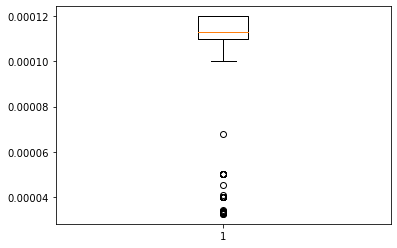

In [14]:
plt.boxplot(data['Energy_Diff'].sample(1000));

# ComputeMean et ComputeMedian

In [15]:
def ComputeMean(c=str):
    
    mean = data[c].mean()
    
    return mean

def ComputeMedian(c=str):
    
    median = data[c].median()
    
    return median

In [16]:
ComputeMedian('File Main Current (A)')

0.130657

# Courbes 
On nous demande de construire des courbes de consommation totale d'énergie selon les deux facteurs d'étalement et des taux de bits redondants. Pour cela, il faut pouvoir identifier les observations selon ces caractéristiques :

In [21]:
file_list = os.listdir(r'C:\Users\Shpend\Downloads\lora-energie-transmission\lora-energie-transmission\data\raw')

data1 = pd.DataFrame()
for f in file_list[1:]:
    df = pd.read_csv(r'lora-energie-transmission\data\raw\\'+f)
    
    # Type de facteur d'étalement, 12 ou 7
    if re.search('energy-125-12[\w]*', f):
        df['SF'] = np.zeros((df.shape[0]))+12
    else: df['SF'] = np.zeros((df.shape[0]))+7
        
    # Nous créons un tableau de caractères
    a = np.chararray((df.shape[0]), unicode=True, itemsize=5)
    # Ajoutez les valeurs que nous voulons, extraites du nom de fichier en utilisant regex
    a[:] = re.findall('(?:energy-125-[127]{1,2}-)(4_[\d]{1})', f)[0].replace('_','/')
    # Créer la colonne
    df['TBR'] = a
    
    
    
    data1 = data1.append(df, ignore_index=True)
data1.shape

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(2682781, 7)

In [22]:
data1.sample(5)

,Timestamp (S),File Main Current (A),File Main Voltage (V),File Main Energy (J),File UART (TXT),SF,TBR
2533707,37.24800,0.130986,3.5,15.315530,NaN,7.0,4/8
2667249,70.63325,0.047222,NaN,30.361100,NaN,7.0,4/8
312984,78.24600,0.130492,3.5,34.467050,NaN,12.0,4/5
1752738,19.20775,0.129649,NaN,6.793571,NaN,7.0,4/5
369071,2.60050,0.038504,NaN,0.347102,NaN,12.0,4/6


Maintenant nous pouvons faire les courbes

In [23]:
# Consommation totale de données pour chaque type de TBR
CE = data1.groupby(['SF', 'TBR']).sum()['File Main Energy (J)']
CE

SF    TBR
7.0   4/5    2.113360e+06
      4/6    2.772479e+06
      4/7    3.492509e+06
      4/8    4.575630e+06
12.0  4/5    6.885575e+06
      4/6    8.336073e+06
      4/7    1.078057e+07
      4/8    1.231324e+07
Name: File Main Energy (J), dtype: float64

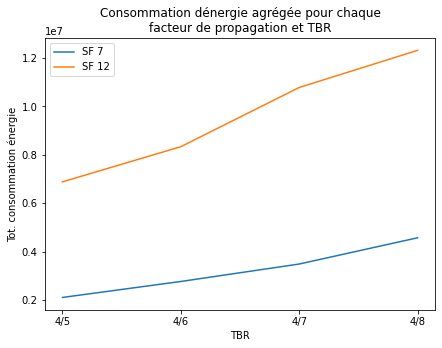

In [24]:
plt.figure(figsize=(7,5))
plt.title('Consommation dénergie agrégée pour chaque\nfacteur de propagation et TBR')
plt.ylabel('Tot. consommation énergie')
plt.xlabel('TBR')
plt.plot(CE[7], label='SF 7')
plt.plot(CE[12], label='SF 12')
plt.legend();

# FIN DE TRAVAIL

# FAIT PAR:

# Shpend Rashiti, Emir Eraslan, Jomath Sembe